# Road Sign Classification with Pytorch
The project presented is a Road Sign Classification task using Pytorch. It is the project inserted in the last chapter of my Bachelor Thesis.<br><br>
## Preparation
In order to be able to carry out the operations in a reasonable time with the available system, it is necessary to use Cuda, which allows to increase the performance using the GPU [5]. More detailed information from: https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html#abstract.<br><br>
The dataset used for this classification is the German Traffic Sign Recognition Benchmark (GTSRB), composed by 39209 training images divided in 43 classes and 12631 test images. This dataset can be download from: https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign.<br><br>
Below some images of the dataset [9].

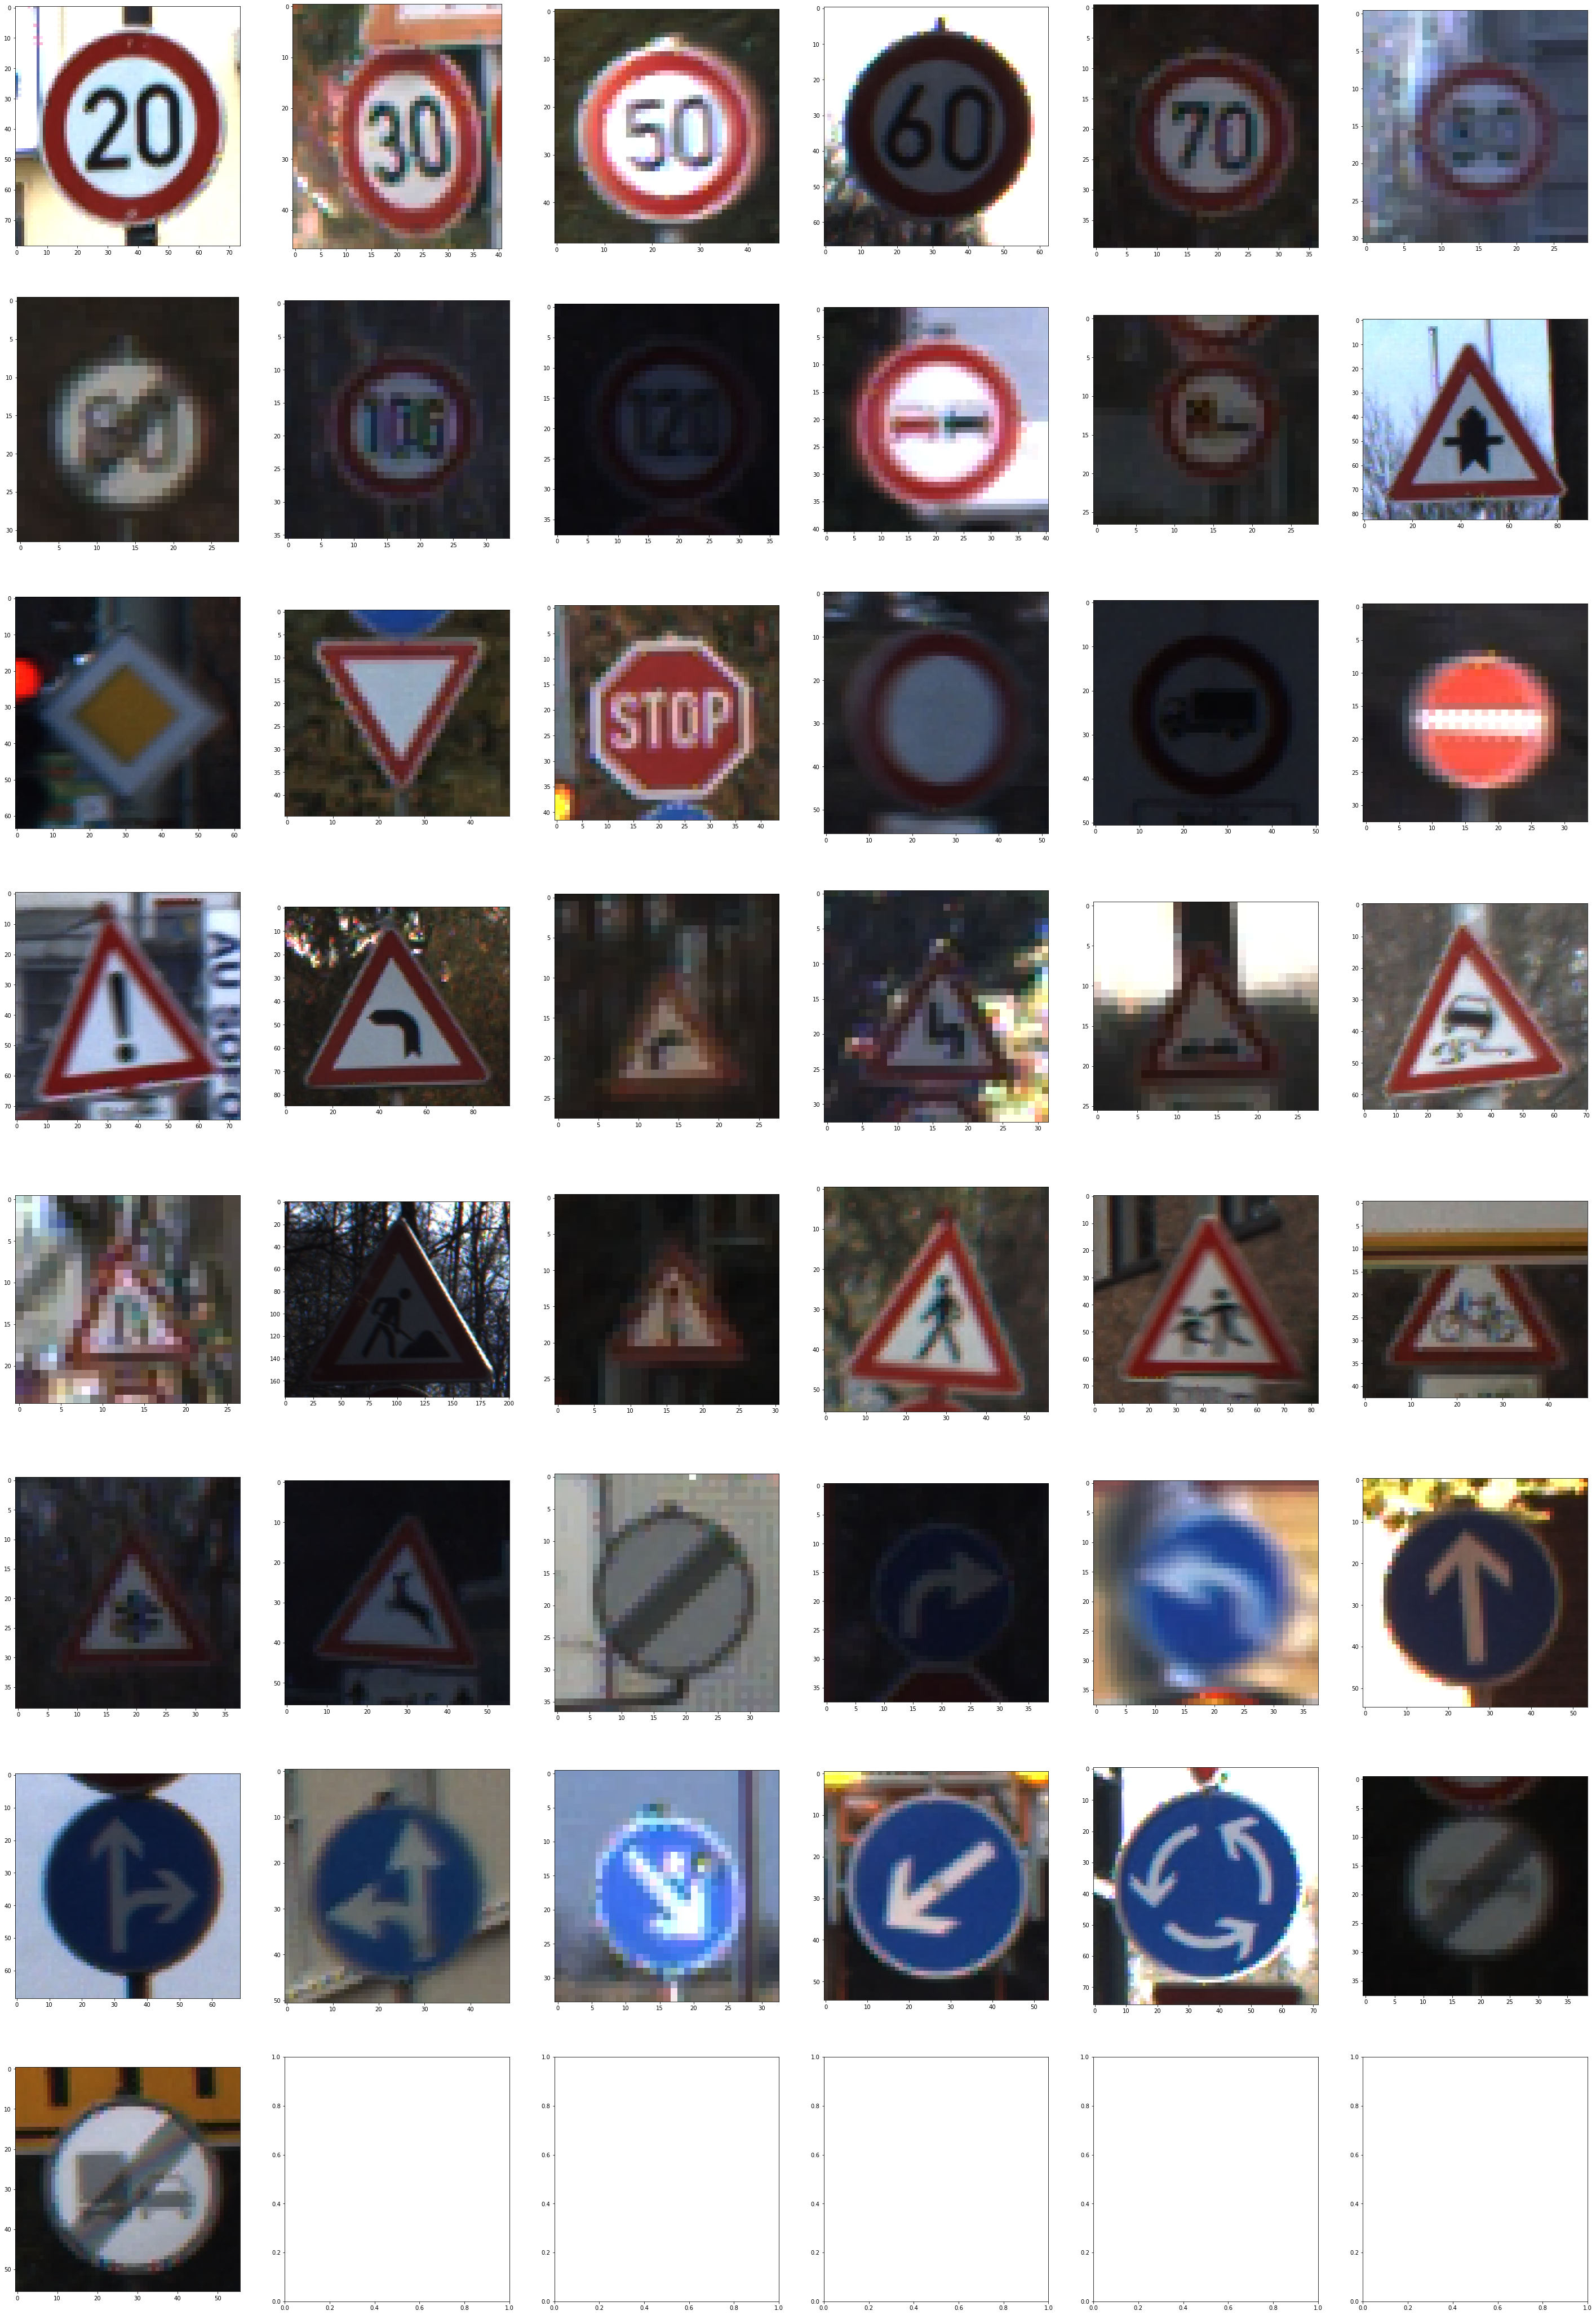

In [1]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
rows = 8
cols = 6
figure, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(50,75))
current_class = 0
for i in range(0, rows):
    for j in range(0, cols):
        if(current_class == 43):
            break
        else:
            folder = 'Data/Train/' + str(current_class)
            r = random.choice(os.listdir(folder))
            file = folder+'\\' + r
            img = Image.open(file)
            axes[i, j].imshow(img)
            current_class +=1

It is also necessary to download the libraries that the project will use. As anticipated before, PyTorch is the module that will be used in the project. To download it, it is possible to check the official documentation: https://pytorch.org/get-started/locally/.

In [2]:
import time
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchsummary import summary

To allow a correct loading of the data and a simple but effective standardization, it is possible to define a transformation.

In [3]:
transformation = torchvision.transforms.Compose([
    torchvision.transforms.Resize([112, 112]),
    torchvision.transforms.ToTensor()
    ])

The method inserted above allows to create a transforms object that has various types of transformations inside, in this case two.<br><br>
The next step is to load the training images. It is necessary to note that ``torchvision.datasets.ImageFolder`` is a method that requires that, inside the target path, the images have to be divided in folder, where each folder represent the belonging class.<br>

In [4]:
path = "Data/Train"
training_data = torchvision.datasets.ImageFolder(root = path, transform = transformation)
print(len(training_data))

39209


After uploading the images, it is necessary to partition the training set in order to obtain a validation test to allow the subsequent performance measurement. The split ratio can easily be 0.8.<br>

In [5]:
ratio = 0.8
number_training_examples = int(len(training_data) * ratio)
number_validation_examples = len(training_data) - number_training_examples
training_data, validation_data = data.random_split(training_data, [number_training_examples, number_validation_examples])
print(len(training_data))
print(len(validation_data))

31367
7842


Once the training set and validation set have been created, it is a good practice to evaluate how many of the examples in each set belong to a specific class. <br>

In [6]:
number_of_classes = 43
training_classes = [0] * number_of_classes
for i in training_data.indices:
    c = training_data.dataset.targets[i]
    training_classes[c] += 1
    
validation_classes = [0] * number_of_classes
for i in validation_data.indices:
    c = validation_data.dataset.targets[i]
    validation_classes[c] += 1

In the code above, an array filled with zeros and with the dimension equal to the number of classes of the training set is created. <br><br>Then, a for loop till the last index of the dataset (length of the dataset) is made, and for each loop, ``c`` will contain the class of the ``i`` image. This is possible due to the structure of the training data folder: it has 43 folders (the number of classes) in which only the signs belonging to that specific class are placed. Thus, for a specific image ``i``, ``c`` will contain the belonging class, that is this case is the name of the folder (a number). For instance, if the index is 0, it will contain the class of the first element in the dataset, that is the name of the folder in with this image is placed, and so on.<br><br>After that, the value of the zeros array in the ``c`` position (the class found previously) will be set at +1 (this mean that since an image with a specific class was found, it is necessary to save this information by incrementing the value of the zeros array at that position). At the end, the array will have saved all the number of time an image belongs to a class.<br><br>The same process is made for the validation set.<br><br>For a correct interpretation of the classes to which the examples belong, it is a good practice to visualize which type of road sign each class refers to, thus a sample. The Python Imaging Library (PIL) will be used, allowing a correct and optimized processing of different image formats [2].

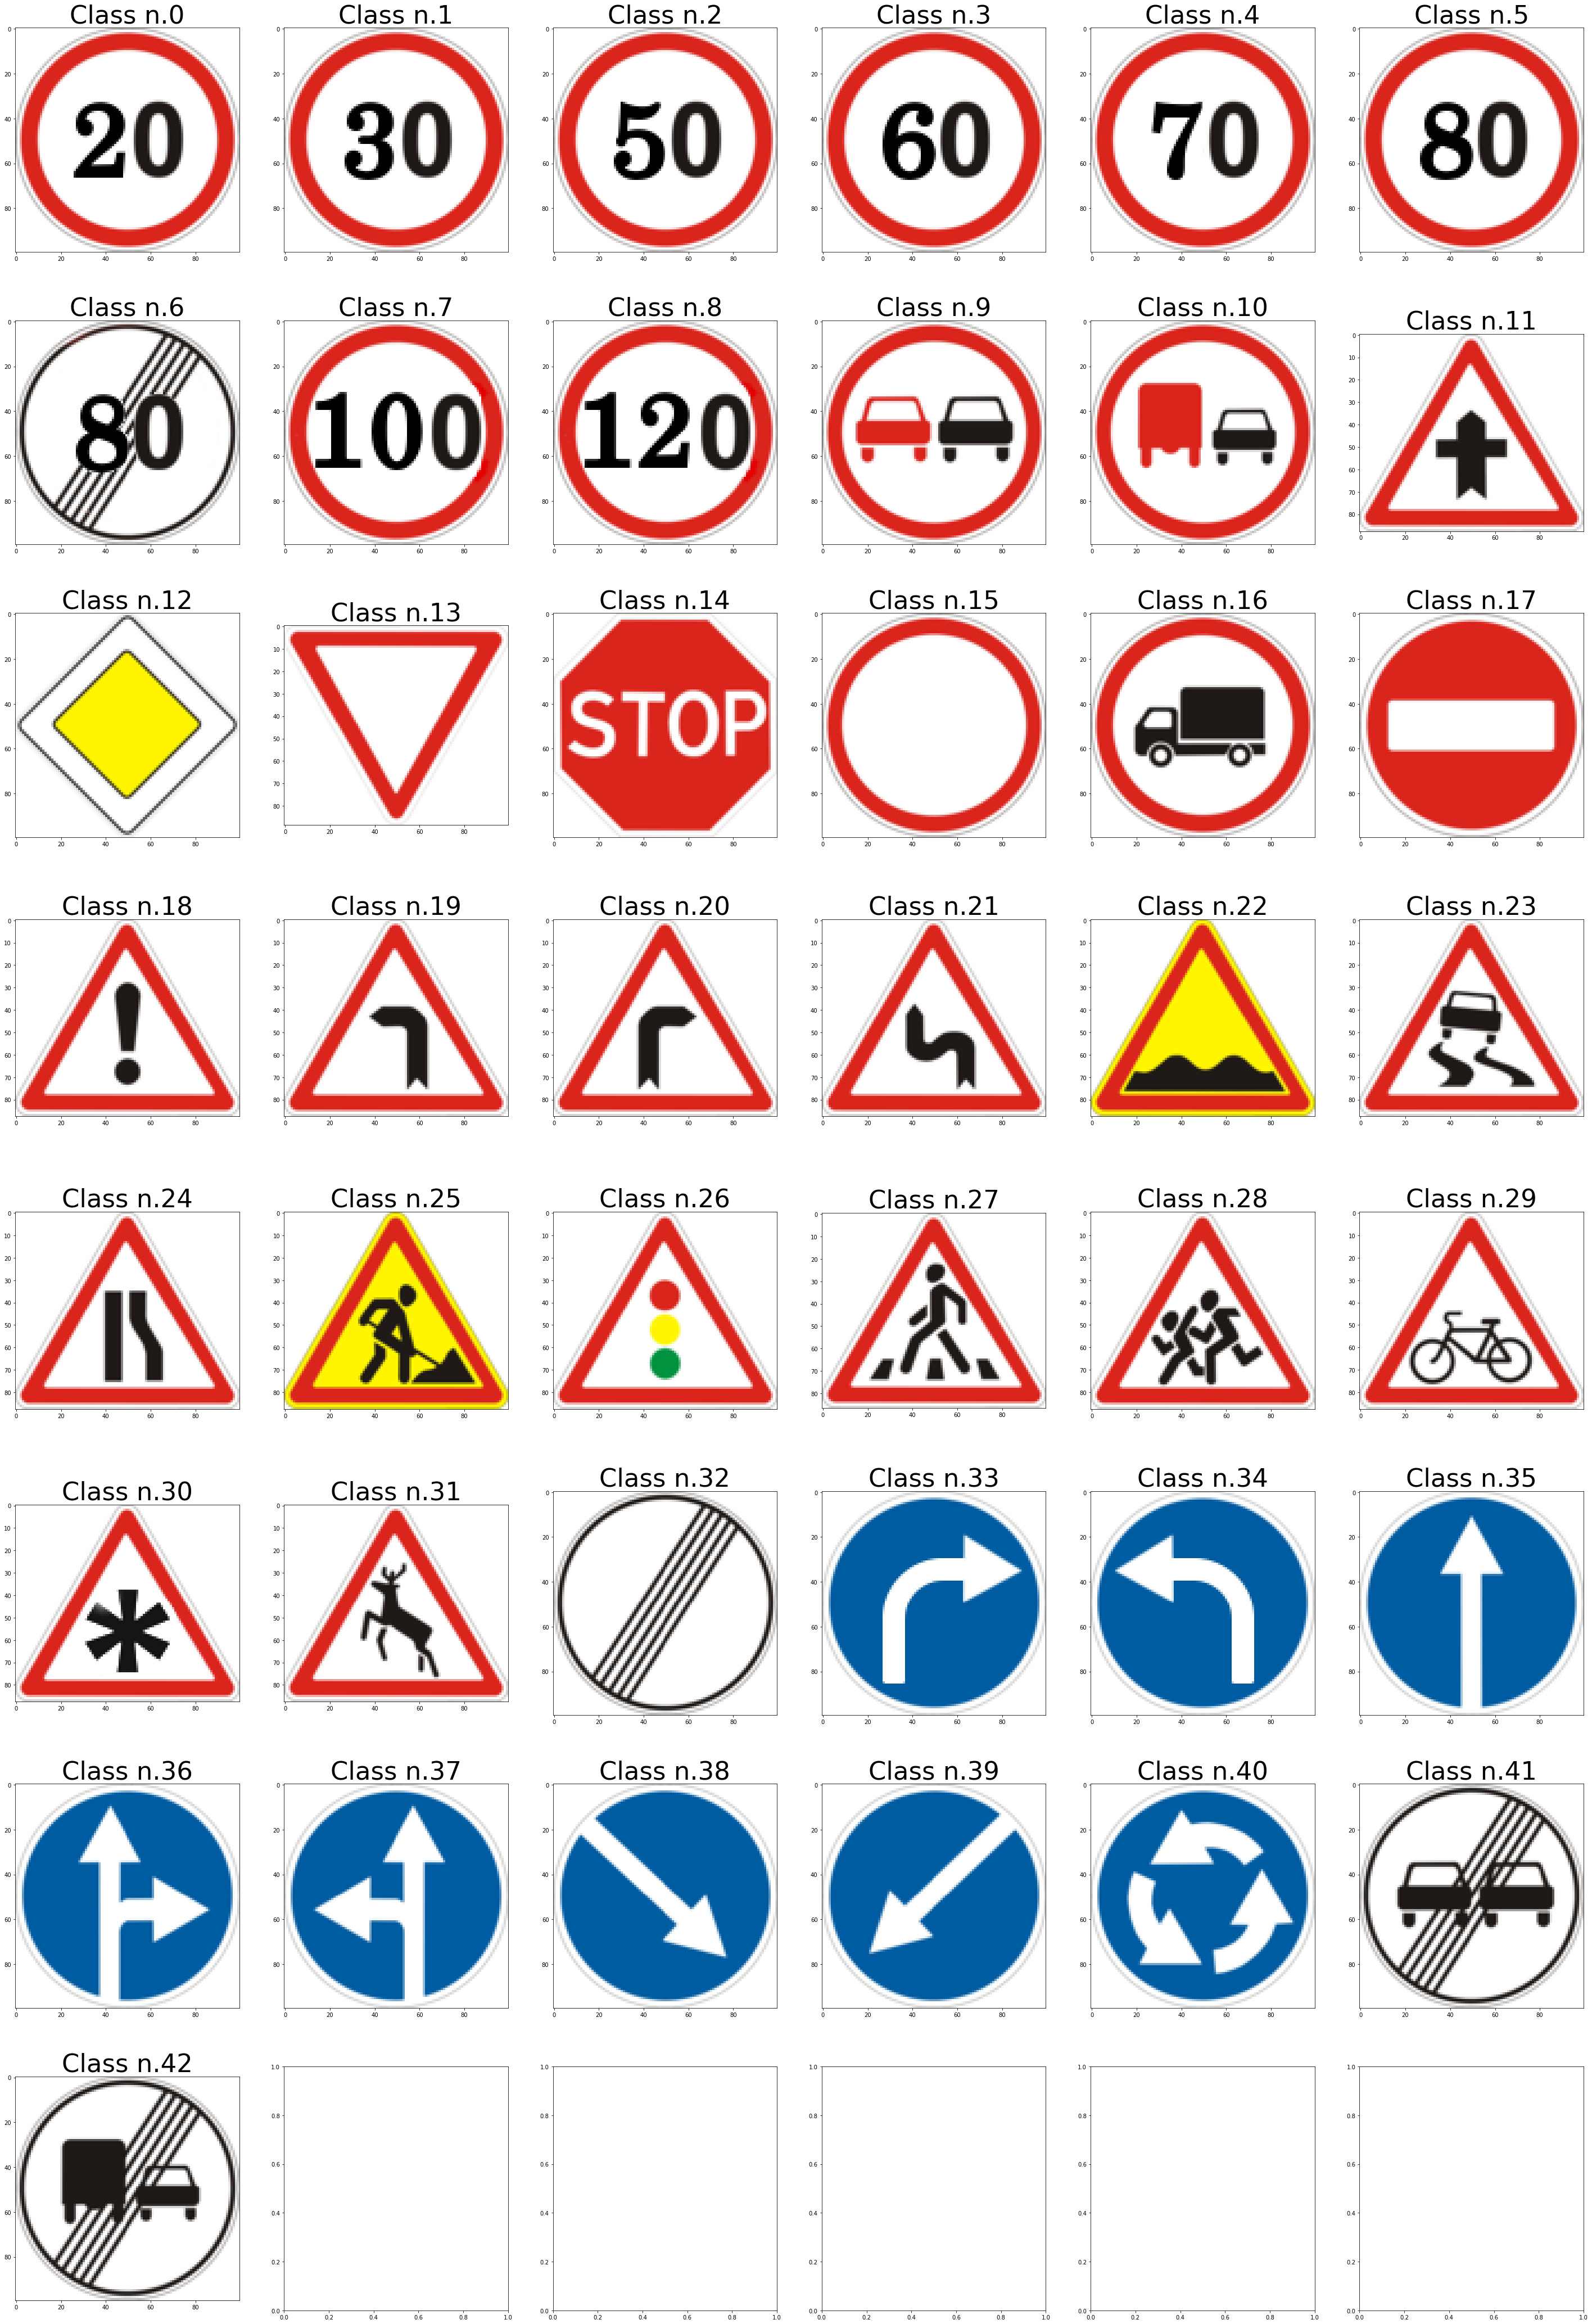

In [7]:
from PIL import Image
rows = 8
cols = 6
figure, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(50,75))
current_class = 0
for i in range(0, rows):
    for j in range(0, cols):
        if(current_class == 43):
            break
        else:
            img = Image.open('Data/Meta/' + str(current_class) + '.png')
            axes[i, j].imshow(img)
            axes[i, j].set_title('Class n.' + str(current_class), fontsize=45)
            current_class +=1

Finally, it is possible to graph the data obtained. As will be visible in the graph, the distributions of the two datasets are similar.

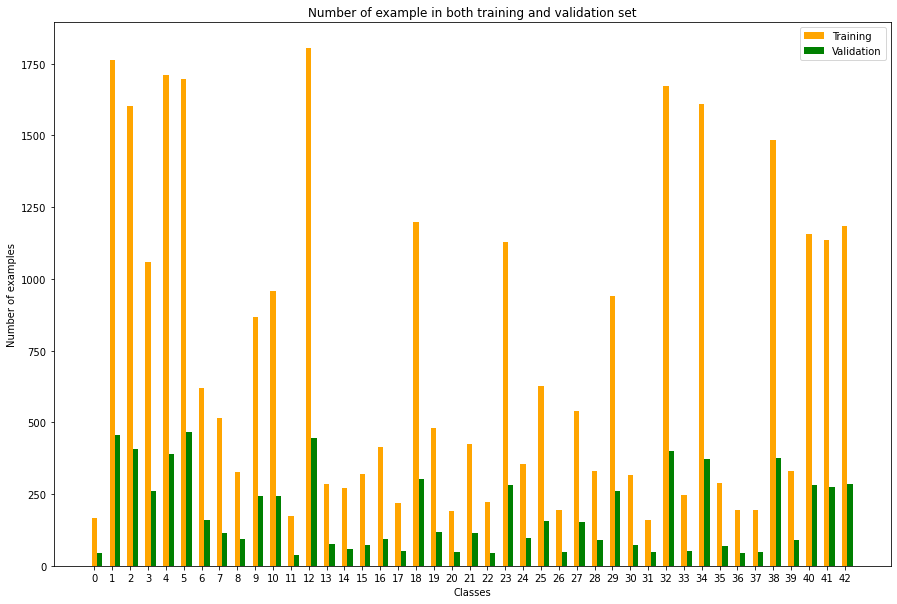

<Figure size 432x288 with 0 Axes>

In [85]:
plt.figure(figsize=[15, 10])
X = np.arange(len(training_classes))
plt.bar(X, training_classes, color = 'orange', width = 0.3)
plt.bar(X + 0.3, validation_classes, color = 'g', width = 0.3)
plt.legend(['Training', 'Validation'])
plt.xticks([i for i in range(number_of_classes)])
plt.title("Number of example in both training and validation set")
plt.xlabel('Classes')
plt.ylabel('Number of examples')
plt.show()

The next step is to create dataloaders that allow a more advantageous way of working with datasets. It may be important to distinguish between dataset and dataloader.<br><br> Dataset is a function that allows to store the examples statically in a data structure, interacting with one data at a time. <br><br>Dataloader is a function that allows a more optimized access to data. Instead of interacting with the dataset one example at a time, the datalader allows to interact with more data at a time: the number of data taken at each iteration is determined by the ``batch_size`` which, as described in the previous chapters, is the number of examples taken to calculate the error function of an epoch, then applied to the gradient descent and backpropagation to update the weights. In this way, when the model requires the calculation of the error function, this function is calculated by taking n examples from the dataloader, where n is the value of the batch size. Furthermore, to allow data shuffling and take n random data at each iteration, one of the dataloader parameters, ``shuffle``, has to be set to true.<br><br>
Regarding the value of the batch size, it is arbitrary but it is good to know that the higher this value, the faster the model will learn, since at each epoch the number of iterations (gradient descent) will be lower since more examples are coming at a time used. However, the complexity increases [3].

In [9]:
batch_size = 256
training_loader = data.DataLoader(training_data, shuffle=True, batch_size = batch_size)
validation_loader = data.DataLoader(validation_data, shuffle=True, batch_size = batch_size)

The next step is the construction of the convolutional neural network that will be used by the model. In this case AlexNet will be used. AlexNet is a CNN that has 8 weights layers (5 convolutional layers and 3 fully connected layers). After each convolutional layer uses max polling and before entering the other layers the activation function ReLu is evaluated [3].<br><br>

In [10]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In this case, the PyTorch module ``torch.nn`` is used to create the network, which allows to work with neural networks. First of all, the class is created by entering ``nn.Module`` as a parameter, an operation that is always required when working with neural networks. When a class is created, it is needed to reassign the value of the ``__init () __`` function, which is the constructor of the class, and then the network structure will be inserted right here. The number of classes of the addressed task will be passed as a parameter.<br><br>
The constructor has to perform two blocks: the extraction of the features using the convolutional layers, and the classification through the fully connected layers. There are two methods called by the constructor itself, `` self.features`` and `` self.classifier``, which through the use of `` nn.Sequential`` are sequential container of operations.<br><br>
Regarding the features extraction block, in line with AlexNet characteristics, 5 convolutional layers are created with ``nn.Conv2d``, which creates a 2D convolutional layer. This method has some parameters, such as the size of the input (the first layer has input = 3 because the input image has 3 RGB channels), the size of the output (which is also the number of convolutional or kernel filters used during this phase), the kernel size, stride, and padding, all seen in previous chapters. After the convolutional layers the 2D polling layers are created with ``nn.MaxPolling12d``, specifying the size. Finally, the ReLu is implemented with ``nn.ReLu``.<br><br>
Regarding the classification step, there are three hidden layers each consisting of a ``nn.Dropout``, which avoids overfitting by optimizing the calculations, a ReLu activation function, and a ``nn.Linear``. The dropout layer allows to set the probability with which the neurons will be stopped and therefore not used. The most used values are 0.3 and 0.5 [3]. The linear function is used to transform the first parameter into the second parameter. So, after three layers, the output is equal to the number of classes.<br><br>
Finally, the forward method is created which constitutes the executive block that the network carries out at each epoch [4].

In [11]:
model = AlexNet(number_of_classes)

It is useful to view the characteristics of the model, especially to obtain information on the parameters, which are the weights that will be updated.

In [12]:
print(summary(model, (3, 112, 112))) 

D:\Programmi\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 56, 56]          1,792
|    └─MaxPool2d: 2-2                    [-1, 64, 28, 28]          --
|    └─ReLU: 2-3                         [-1, 64, 28, 28]          --
|    └─Conv2d: 2-4                       [-1, 192, 28, 28]         110,784
|    └─MaxPool2d: 2-5                    [-1, 192, 14, 14]         --
|    └─ReLU: 2-6                         [-1, 192, 14, 14]         --
|    └─Conv2d: 2-7                       [-1, 384, 14, 14]         663,936
|    └─ReLU: 2-8                         [-1, 384, 14, 14]         --
|    └─Conv2d: 2-9                       [-1, 256, 14, 14]         884,992
|    └─ReLU: 2-10                        [-1, 256, 14, 14]         --
|    └─Conv2d: 2-11                      [-1, 256, 14, 14]         590,080
|    └─MaxPool2d: 2-12                   [-1, 256, 7, 7]      

Now it is necessary to define what kind of optimization will be performed by the model and the error function that will be used.<br><br> First of all, it is essential to start from the learning rate. As seen in the previous sections, gradient descent is the main optimization algorithm used in neural networks. It is based on finding the right adjustment value of the weights by moving the value of the weights down to the curve of the error function. This movement is possible by deciding the direction of this movement (derivative of the error with respect to the weight) and the length of this movement, i.e. the learning rate: it therefore represents the speed with which the algorithm moves the weights down at each epoch. If this value is low, at each epoch the weights will be moved slowly towards the absolute minimum of the error function, and using so many epochs, the algorithm will be able to obtain an almost perfect error function, even if the times will be quite long. If this value is large, it will take less time to get a good error function, but there can be a problem: if the step is too long, instead of going down, the weights will go down and up again, paradoxically creating an infinite process that it will never bring the weights near the absolute minimum [3].<br><br>

In [13]:
learning_rate = 0.001
optimization = optim.Adam(model.parameters(), lr=learning_rate)

Regarding the optimization algorithm, Adam is used. It is based on the gradient descent, but with some differences. It has been seen that if the learning rate is high, this implies that the weight does not drop towards the minimum, but can diverge from it. For this, Adam makes sure that steps in the horizontal direction with respect to the minimum can have large oscillations, while keeping the oscillations in the direction of the minimum small. This allows the weights to move quickly in the horizontal direction of little importance, while controlling the movement towards the target. In PyTorch, model parameters and learning rate have to be passed to this optimizer.

Cross entropy will be used as an error function. As seen in the previous chapters, it is suitable for classification problems.

In [14]:
error_function = nn.CrossEntropyLoss()

Since the subsequent model training operations will use enough computational power, it is necessary to convert the functionalities for a correct use with Cuda.

In [15]:
if torch.cuda.is_available():
    model = model.cuda()
    error_function = error_function.cuda()

Finally, it is needed to define a function that calculates the accuracy of the model. 

In [16]:
def accuracy(prediction, true_value):
    class_predicted = prediction.argmax(1, keepdim = True)
    correct = class_predicted.eq(true_value.view_as(class_predicted)).sum()
    a = correct.float() / true_value.shape[0]
    return a

It is good to remember that the accuracy is the relationship between the number of examples correctly predicted and the total number of examples.<br><br>
To understand what this function does, it is necessary to study row by row this block. First of all, each of the two parameters of the function are tensors whose size will be equal to the number of images that, for each epoch, are supplied to the system. This number is the batch size. <br><br>
Regarding the first parameter, ``prediction``, each value of this tensor is another tensor representing the output that arrives from the model after the feedforward phase of an image (among all those supplied to the model during an epoch). It is good to remember what happens at the end of this phase. As described extensively in the previous chapters, in classification problems, an input, through the feedforward phase, will be associated with a prediction. This prediction is the class predicted by the model. In practice, the final layer of the neural network is composed of as many neurons as there are classes in the problem addressed. Furthermore, each neuron in this layer predicts the probability that the input belongs to one of the classes. Normally, the neuron corresponding to the true class of the input will have a value close to 1, while all the others close to 0. Thus, each value within the prediction tensor is a tensor that has 43 values, each of which represents the probability that the faced image related to this specific output belongs to that specific class.<br><br> 
Regarding the other parameter, ``true_value``, each value of this tensor is another tensor representing the true class to which an image belongs (among all those supplied to the model during an epoch). <br><br>
For example, if the batch size is 5, each of the two tensors has 5 other tensors: each tensor in ``prediction`` contains 43 values, which are the probabilities that each batch image belongs to each of the classes, and each tensor in ``true_value`` contains the real class of each batch image.<br><br>
Inside the function, ``class_predicted`` is a tensor with the size equal to batch size. Each value of this tensor is the index of the element within the respective prediction tensor which has the highest value. This simply means that this tensor takes the classes that the model has predicted as the most likely for each of the batch images.<br><br>
Now is the time to compare this tensor with ``true_value``, which respectively contain the predicted classes of each batch image and the real class of each batch image. ``class_predicted.eq`` returns True if an element of ``class_predicted`` is equal to the respective element of ``true_value``, False otherwise. ``correct`` contains the sum of these results, where True is meant as 1. If for example the tensors have 5 values each, and the comparison says that 3 pairs have been true and 2 false, ``correct`` is equal to 3.<br><br>
Finally, ``a`` implements the direct formula for calculating the accuracy: the number of correct predictions (within the ``correct`` value) and the number of examples, which in this case is the size of the tensor of the true classes of the images, but also the number of images passed to the model at each epoch, i.e. the batch size. In this case, the size of the ``true_value`` tensor is used [3].

<br><br><br>
## Training

This section of the project will be focused on the training process of the network created before. As discussed in the previous chapters, the training procedure consists of the feedforward, calculation of the metrics to evaluate the performance of the model, and the backpropagation to adjust the weights in relation to the calculated metrics.<br><br>
All the elements needed to execute the training have already been defined. The dataloaders for training and validation have been defined, dividing the initial dataset into iterations consisting of the processing of n images, where n is the batch size. A CNN (AlexNet), an optimizer (Adam), an error function (cross entropy) and an accuracy function have been created. Now all that remains is to create the functions that will implement a training cycle and a validation cycle. However, it is necessary to define how many training cycles, and therefore of validation, the model will run. The epoch is a loop in which the model trains and validates n images, where n is the batch size. The greater the number of epochs, the greater the cycles in which the model updates the parameters and the greater the possibility of obtaining good performances, even if the times will increase as there will be more cycles.<br><br>

In [17]:
epochs = 15

In [18]:
def train(model, loader, optimizer, error_func):
    final_loss = 0
    final_acc = 0
    model.train()
    
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output, _ = model(images)
        loss = error_func(output, labels)
        final_loss += loss.item()
        acc = accuracy(output, labels)
        final_acc += acc.item()
        loss.backward()
        optimizer.step()
        
    return final_loss / len(loader), final_acc / len(loader)

In the code above, the function that will be used at each epoch by the model to perform a training cycle is implemented. The function takes as parameters the model (the CNN, created previously), a dataloader, an optimizer and an error function.<br><br> Within the function, two variables have been defined, ``final_loss`` and ``final_acc`` which, respectively, will contain the total error that the model has encountered at the end of the training, i.e. at the end of the feedforward and after the evaluation of the error function, and the accuracy calculated following the output formed by the model at the end of the training procedure. <br><br>The training begins with the ``model.train()`` method, which tells network layers, such as Dropout and others, that the training procedure has begun. <br><br>At this point, the model cyclically takes a window of data from the dataset to train with respect to this data. The window has size n equal to the batch size, so at each for loop, n random data will be taken. The cycles end when the number of data used equals the total number of data in the training dataset. For example, if the training dataset has 1000 data in total and the batch size is 150, at each for cycle it will take 150 random data within the total dataset: there will then be 7 cycles, the first 6 of which will take 150 random data from the dataset, and the last one will take 100. In particular, at each for loop, the n images and the corresponding n classes of belonging are taken, and optimized for use with Cuda.<br><br>
The training cycle can begin. First of all, ``optimizer.zero_grad()`` eliminates the gradients calculated by the optimizer in the previous step (epoch). After that, the model output is saved in `` output ``. Remember that, as already analyzed in the part about the accuracy function, the output of the model is a tensor. Each value of this tensor is another tensor representing the output that arrives from the model after the feedfarward phase of an image (among all those supplied to the model during an epoch). Next, the error function is applied between predictions (``output``) and the real classes (``labels``) and its value will be added to the ``final_loss`` variable. Similarly, the accuracy between predictions and real classes is calculated, and this value will be added to the ``final_acc`` variable. After these steps, ``loss.backward()`` is executed. This function is a method of the previously calculated error function and allows to calculate the derivative of the error with respect to the parameters (weights) of the data taken from the model in this training cycle. With ``optimizer.step()``, the parameters will actually be updated, thus performing backpropagation.<br><br>
At the end of each for loop, the model parameters were updated with respect to the n data that the model took to perform the training procedure. At the end of the for loop, ie when the number of data used equals the total number of data within the dataset, an epoch will end. At the end of each epoch, there will be the two variables ``final_loss`` and ``final_acc`` which will contain the sum of each function erorre and accuracy calculated for each group of data (mini-batch) taken from the system. Finally, the function returns two values: the error found by the model during an epoch, and the accuracy, both calculated by dividing ``final_loss`` and ``final_acc`` by the size of the dataloader.

<br><br>It may seem that the training procedure is sufficient to ensure that the model, using examples, will be able to learn how to maximize the performance of the model in the problem faced, ie the classification of road signs. In reality, the matter is different, since, as has been seen in the first chapters, the models can incur underfitting or overfitting. <br><br>Underfitting is the situation in which the model operates ineffectively in the training set, resulting in a high error and low accuracy in this data set. Overfitting is the situation where the model solves the problem too well using the training set. This is because, instead of learning the features of the data, it learns all the training examples.<br><br>To solve the problem, it is necessary to check the results obtained on the validation test, running the evaluation: if the model has good results on the training set and low on the validation test, then it is in overfitting. If the model with low results in the training set, it is underfitting. The goal is to create a model that works well on both sets [3].<br><br>
Thus, an evaluation function is necessary.

In [19]:
def evaluate(model, loader, optimizer, error_func):
    final_loss = 0
    final_acc = 0
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            output, _ = model(images)
            loss = error_func(output, labels)
            acc = accuracy(output, labels)
            final_loss += loss.item()
            final_acc += acc.item()
    
    return final_loss / len(loader), final_acc / len(loader)

The function is similar to train, but with some differences. The goal in the validation test is to pass new images to the model without updating the weights. Consequently, it is checked whether the model performs well even with data never seen before during training. As a result, the ``model.train ()`` function is not used, but ``model.eval ()``, which tells the model to only perform the feedforward step and calculate the error and accuracy. Also, the ``torch.no_grad ()`` function tells the model not to calculate the gradient. The next block of code is the same as the training function, and eventually returns the accuracy and error the model encountered in an epoch using the validation set [3].<BR><BR>
At this point, the complete model training and validation procedure can be defined on all the data of the training set and validation set.

In [36]:
training_loss_list = [0] * epochs
training_acc_list = [0] * epochs
validation_loss_list = [0] * epochs
validation_acc_list = [0] * epochs

for epoch in range(epochs):
    print("Epoch %d/%d: " % (epoch+1, epochs))

    training_start_time = time.monotonic()
    print('The training has started.')
    training_loss, training_acc = train(model, training_loader, optimization, error_function)
    training_end_time = time.monotonic()
    print('The training has finished. Total time: %.2f seconds, Accuracy: %.2f%%, Loss: %.4f' % (training_end_time - training_start_time, training_acc * 100, training_loss))

    validation_start_time = time.monotonic()
    print('The validation has started.')
    validation_loss, validation_acc = evaluate(model, validation_loader, optimization, error_function)
    validation_end_time = time.monotonic()
    print('The validation has finished. Total time: %.2f seconds, Accuracy: %.2f%%, Loss: %.4f' % (validation_end_time - validation_start_time, validation_acc * 100, validation_loss))
    
    training_loss_list[epoch] = training_loss
    training_acc_list[epoch] = training_acc
    validation_loss_list[epoch] = validation_loss
    validation_acc_list[epoch] = validation_acc
    print(' ')

Epoch 1/15: 
The training has started.
The training has finished. Total time: 468.58 seconds, Accuracy: 10.64%, Loss: 3.2675
The validation has started.
The validation has finished. Total time: 135.69 seconds, Accuracy: 29.96%, Loss: 2.2581
 
Epoch 2/15: 
The training has started.
The training has finished. Total time: 106.69 seconds, Accuracy: 43.70%, Loss: 1.6831
The validation has started.
The validation has finished. Total time: 15.72 seconds, Accuracy: 58.97%, Loss: 1.1721
 
Epoch 3/15: 
The training has started.
The training has finished. Total time: 116.70 seconds, Accuracy: 67.36%, Loss: 0.9402
The validation has started.
The validation has finished. Total time: 15.33 seconds, Accuracy: 85.19%, Loss: 0.4478
 
Epoch 4/15: 
The training has started.
The training has finished. Total time: 120.66 seconds, Accuracy: 86.69%, Loss: 0.3995
The validation has started.
The validation has finished. Total time: 16.00 seconds, Accuracy: 95.20%, Loss: 0.1646
 
Epoch 5/15: 
The training has s

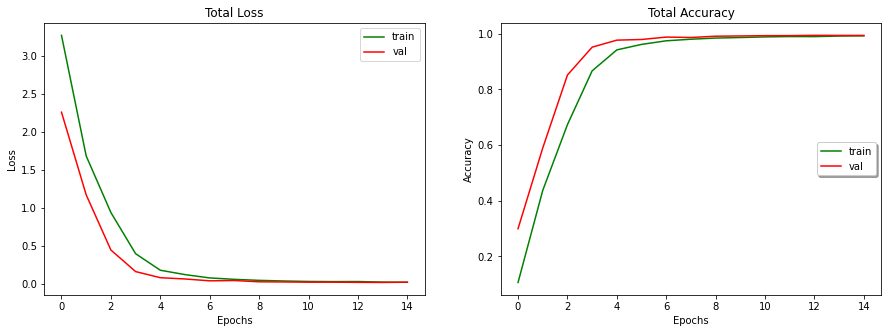

In [37]:
figure, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(training_loss_list, label="train", color='green')
axs[0].plot(validation_loss_list, label="val", color ='red')
axs[0].set_title("Total Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)
axs[1].plot(training_acc_list, label="train", color='green')
axs[1].plot(validation_acc_list, label="val", color='red')
axs[1].set_title("Total Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

As it is possible to see, the model achieved good results, with an accuracy over 99%. However, it is not always easy to get good performances from a model. The factor that allows to obtain good results both in the training set and in the validation test, and to obtain a model that has neither underfitting nor overfitting is a good choice of hyperparameters.<br><br>
First of all, it is necessary to understand if there are data or algorithms at the root of the problem. For example, if the model performs poorly on the training set, it is clear that the model is not using the available data well, so it is not necessary to use more data. If there is an overfitting situation, it is probably needed to use more data, as the model does not learn the features but relies only on learning the training data.<br><br>
As regards the hyperparameters, they are parameters that are not updated by the model training procedures (such as weights and biases), but they have to be modified and set according to the problem faced, the dataset available, and the metrics obtained after the phase of training and validation. There are many hyperparameters that are needed to be adjusted.<br><br>
The hyperparameters concerning the network are the number of layers, which in the case of the project is 8, the number of neurons, which in the case of the project varies according to the number of filters used in the convolutional layers and the output size of each fully connected layer, and the type of activation function.<br><br>
Linked to the learning phase, there are the most important hyperparameters. Leaning rate and batch size have already been extensively described. The epoch is a complete process where the model uses the entire dataset once to train using this dataset. During an epoch, the model takes a number of random examples at a time, until the total number of data in the dataset has been reached. More epochs correspond to more learning by the model, which uses more cycles to learn more features. Therefore, by checking the accuracy and error generated by the model at each epoch, it is possible to understand if the number of epochs is good or should be changed. In the case of the project, at epoch 14, the accuracy and error seemed to increase very little, and this suggests that it would not have made much sense to increase the number of epochs, because the model would have obtained a very small increase in performance, opposed to a big time increase [3].<br><br>

To prevent the model obtained from being lost, it is a good practice to save it. It will be saved in the folder 'Model' inside the working directory.

In [39]:
name = "Model/model_trained.pth"
torch.save(model.state_dict(), name)

To load the model, it is possible to run the code:

In [ ]:
name = "Model/model_trained.pth"
model = AlexnetTS(number_of_classes)
model.load_state_dict(torch.load(name))
model = model.cuda()

<br><br><br>
## Inference

The last stage of the project is inference. To detail what is meant by inference, it is necessary to spend some words about training, validation and test set.<br><br>
The training set is the dataset used by the model to learn. During this procedure, the model processes the data by extracting features and, based on the prediction and the error function, adjusts the model parameters. The validation test is used during the evaluation phase. In short, during this phase, the model uses this data (which is unknown to the model) not to learn (since no gradient is calculated) but to obtain a first measure of the system performance with data that was not used in the training. Furthermore, the validation set is important because it allows the tune of the hyperparameters: since the model will not learn from this set, the validation test can be used cyclically to view the performances and, if necessary, modify the hyperparameters. The test set is used in the inference phase. While, as we have seen, the evaluation can be performed cyclically several times until the final performances are not acceptable (in the case of the project, at each epoch both a training cycle and an evaluation cycle have been performed), in general the inference is performed only once, after training, to give the final performance of the model in solving the problem faced, generally using new data never seen before (ie not present in the training or in the validation set) [6].<br><br>

In [40]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import natsort

In [41]:
class CustomDataSet(data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [77]:
test_path = "Data/Test"
test_data = CustomDataSet(test_path, transform=transformation)
print(len(test_data))
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)

12630


As was done previously, the test set needs to be loaded. The procedure is different from that of loading the training set, performed through the use of a method that required the subdivision of the images into folders based on the class they belong to. In this case, the test set consists of a single folder with all the images, without being divided into classes (sub-folders). A function from the PyTorch forum was used for simplicity [8].<br><br>
Next, the test data has to be loaded into a dataloader to allow iteration of the images. In this case, at each iteration, it will be necessary to obtain one image at a time, since testing must be done for each image. Thus, the batch size is 1 image per batch. Moreover, ``shuffle`` is set at false because, at each iteration, a different image from those already evaluated has to be taken. Finally, to load the test data the same training transformation has been used.<br><br>After loading the test set into the dataloader, it is possible to proceed with the classification. First, reading the real classes of each test set image is required.

In [78]:
info = pd.read_csv("Data/Test.csv")
number_of_examples = len(info)
real_labels = list(info.ClassId)

In ``number_of_examples`` there is the number of test images, while in ``real_labels`` there are the classes of each test image.

In [79]:
n = range(number_of_classes)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

List of labels : 
Actual labels 	--> Class in PyTorch
	0 	--> 	0
	1 	--> 	1
	10 	--> 	2
	11 	--> 	3
	12 	--> 	4
	13 	--> 	5
	14 	--> 	6
	15 	--> 	7
	16 	--> 	8
	17 	--> 	9
	18 	--> 	10
	19 	--> 	11
	2 	--> 	12
	20 	--> 	13
	21 	--> 	14
	22 	--> 	15
	23 	--> 	16
	24 	--> 	17
	25 	--> 	18
	26 	--> 	19
	27 	--> 	20
	28 	--> 	21
	29 	--> 	22
	3 	--> 	23
	30 	--> 	24
	31 	--> 	25
	32 	--> 	26
	33 	--> 	27
	34 	--> 	28
	35 	--> 	29
	36 	--> 	30
	37 	--> 	31
	38 	--> 	32
	39 	--> 	33
	4 	--> 	34
	40 	--> 	35
	41 	--> 	36
	42 	--> 	37
	5 	--> 	38
	6 	--> 	39
	7 	--> 	40
	8 	--> 	41
	9 	--> 	42


This operation was done for the way in which the model predicts the probabilities that an input image belongs to the various classes. In fact, when an image is passed to the model, the model outputs a tensor composed of 43 values: each value is relative to the probability that the image belongs to a class. However, the order of the values of the tensors is not in ascending or descending order, but follows another order, the same as that of the ``labels`` list at the top. For example, the model has output a tensor related to the prediction of the classes of an image. The ninth value of this tensor is the possibility that the image has the class defined by that value. What class is it? it is necessary to check the relation described above and see that the entry with index 8 of the ``labels`` list corresponds to class 16, due to the ordering of the model output, and so on.<br><br>After these assumptions, the classification process is ready to be initialized.

In [80]:
predictions = []
corrects = 0
i = 0
with torch.no_grad():
    model.eval()
    for image in test_loader:
        image = image.cuda()
        pred = model(image)
        _, pred = torch.max(pred[0], dim=1)
        pred = pred.cpu().numpy()
        
        pred = pred[0]
        pred = labels[pred]
        
        predictions.append(pred)

        if real_labels[i] == pred:
            corrects += 1

        i += 1

print("Number of correctly classified images = %d" % corrects)
print("Number of incorrectly classified images = %d" % (number_of_examples - corrects))
print("Final accuracy = %f" % (corrects / number_of_examples))

Number of correctly classified images = 12131
Number of incorrectly classified images = 499
Final accuracy = 0.960491


In the code above, two elements have been defined: ``predictions``, which will contain all the predictions of each image in the test set, and ``corrects``, the number of correct predictions. Then, the ``model.eval ()`` method was used to start the evaluation (i.e. the model will predict the classes without changing the parameters and learning). With ``model (image)`` the model outputs the predictions, which are a tensor whose values indicate the probabilities that the input belongs to the classes. The order of these values is the same as that of the ``labels`` list described above. Next, the highest value of this tensor is taken (which corresponds to the most likely predicted class) which is again a tensor. This tensor has been converted into a numerical value. Finally, to obtain the effective class, this value constitutes the index of an element of the ``labels`` list, within which there will be the predicted class, according to the process described above. This predicted class is compared with the real one, and if they are equal, corrects will be increased.<br><br>The ``classification_report()`` method allows to specify additional performance measures to evaluate the model [1] [7].

In [81]:
print(classification_report(real_labels, predictions))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        60
           1       0.95      0.95      0.95       720
           2       0.92      0.99      0.95       750
           3       0.97      0.98      0.97       450
           4       0.99      0.96      0.98       660
           5       0.97      0.92      0.95       630
           6       0.96      0.81      0.88       150
           7       0.97      0.97      0.97       450
           8       0.98      0.97      0.97       450
           9       1.00      0.99      1.00       480
          10       0.99      0.98      0.99       660
          11       0.90      0.99      0.94       420
          12       0.95      0.92      0.93       690
          13       0.97      1.00      0.98       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       0.98      1.00      0.99       150
          17       1.00    

The project is finished. To conclude, the main elements and the final performances can be summarized: the training phase allowed to obtain a model with an accuracy equal to 99% after 15 epochs, also confirmed by the evaluation using the validation test. Finally, the model also performed optimally with the test set, obtaining an accuracy of 95% and excellent metrics such as precision and recall.

# References
[1] PyTorch, n.d., https://pytorch.org/. Accessed 5 July 2021.<br>
[2] Pillow, n.d., https://pillow.readthedocs.io/en/stable/. Accessed 5 July 2021.<br>
[3] Mohamed Elgendy, 2020, Deep Learning for Vision Systems, Manning Pubns Co.<br>
[4] Medium, n.d., https://medium.com/swlh/scratch-to-sota-build-famous-classification-nets-2-alexnet-vgg-50a4f55f7f56. Accessed 6 July 2021.<br>
[5] Cuda, n.d., https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html#abstract. Accessed 6 July 2021.<br>
[6] Tarang Shah, 2017, https://tarangshah.com/blog/2017-12-03/train-validation-and-test-sets/. Accessed 8 July 2021.<br>
[7] Krishnamurthy Suraj, 2020, A Tutorial on Traffic Sign Classification using PyTorch, Medium, https://mailto-surajk.medium.com/a-tutorial-on-traffic-sign-classification-using-pytorch-dabc428909d7. Accessed 8 July 2021.<br>
[8] Chilamkurthy Sasank, n.d., https://pytorch.org/tutorials/beginner/data_loading_tutorial.html. Accessed 8 July 2021.<br>
[9] Houben Sebastian, Stallkamp Johannes, Salmen Jan, Schlipsing Marc, Igel Christian, 2013, Detection of Traffic Signs in Real-World Images: The German Traffic Sign Detection Benchmark, 1288.